Word Embeddings
===============

Preparing our Data
----------------------

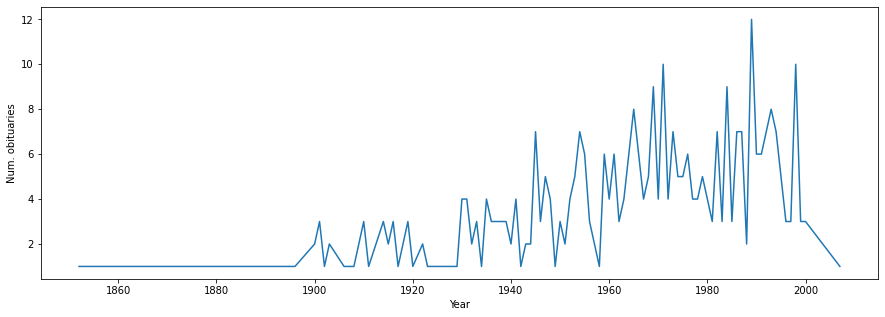

In [1]:
import pandas as pd

manifest = pd.read_csv('data/session_three/manifest.csv', index_col=0)
manifest = manifest.assign(YEAR = pd.to_datetime(manifest['YEAR'], format='%Y').dt.year)

manifest.groupby('YEAR').count().plot(
    figsize=(15, 5),
    y='NAME',
    ylabel='Num. obituaries',
    xlabel='Year',
    legend=False
);

In [2]:
for idx in manifest.sample(5).index:
    name, date = manifest.loc[idx, 'NAME'], manifest.loc[idx, 'YEAR']
    print(f"{name} ({date})")

Alfred Hitchcock (1980)
Pope Paul VI (1978)
The Challenger (1986)
Rex Harrison (1990)
Lou Gehrig (1941)


### Text Cleaning

In [3]:
import spacy

nlp = spacy.load('en_core_web_md')

In [4]:
import glob

def lazy_load(paths):
    for path in paths:
        doc = open(path, 'r')
        yield doc.read()
        
def clean(doc):
    cleaned = []
    for token in doc:
        if token.is_alpha:
            if token.is_stop == False and len(token) > 2:
                token = token.lemma_
                token = token.lower()
                cleaned.append(token)
                
    return cleaned

### Handling `PERSON` tokens

In [5]:
def convert_person(doc):
    tokens = [token.text for token in doc]
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            start = ent.start
            end = ent.end
            
            for idx in range(start, end):
                tokens[idx] = 'PERSON'
    
    result = []
    for idx, token in enumerate(tokens):
        if token == 'PERSON':
            if idx == 0:
                result.append(token)
            elif tokens[idx-1] == 'PERSON':
                continue
            else:
                result.append(token)
        else:
            result.append(token)
                
    result = ' '.join(result)
    result = nlp(result)
    
    return result

In [6]:
doc = nlp("Eric asked Kate about what she is learning. Kate replied, 'I am learning NLP!'")
convert_person(doc)

PERSON asked PERSON about what she is learning . PERSON replied , ' I am learning NLP ! '

In [7]:
def prepare_doc(doc):
    no_person_ents = convert_person(doc)
    cleaned = clean(doc)
    
    return cleaned

In [8]:
paths = glob.glob('data/session_three/obits/*.txt')
to_process = lazy_load(paths)

corpus = [clean(doc) for doc in nlp.pipe(to_process)]

Building a Model
--------------------

In [9]:
from gensim.models import Word2Vec

model = Word2Vec(
    vector_size=300,
    window=5,
    min_count=1,
    sorted_vocab=1,
    seed=357
)

In [10]:
model.build_vocab(corpus)
model.train(corpus, total_words=model.corpus_total_words, epochs=5)

(2142833, 2209595)

Model Exploration I: Word Sense
---------------------------------------

In [11]:
n_tokens = len(model.wv)
print(f"Number of unique words in the model: {n_tokens:,}")

Number of unique words in the model: 29,330


In [12]:
import random

vocab = model.wv.index_to_key

for token in random.sample(vocab, 5):
    print(token)

horton
suffolk
station
margrethe
efficacy


In [13]:
rand_token = random.choice(vocab)
rand_idx = model.wv.key_to_index[rand_token]

print(f"The index position for '{rand_token}' is {rand_idx}")

The index position for 'float' is 8315


In [14]:
model.wv[rand_idx]

array([ 2.53769271e-02,  2.58813128e-02, -1.97694413e-02, -3.70707735e-02,
        2.39697136e-02, -2.34140530e-02, -7.79363140e-03,  4.68314067e-03,
       -1.03628673e-02, -5.01485309e-03,  3.02560795e-02, -4.32379059e-02,
       -2.81230267e-03, -5.03521971e-03,  2.01332625e-02, -7.70108262e-03,
       -2.54807211e-02,  2.05890350e-02, -1.73596554e-02,  1.38997119e-02,
        4.36460413e-02, -5.15849814e-02,  3.71594727e-02,  1.81837529e-02,
       -1.07627651e-02,  2.65141670e-02,  4.18003239e-02,  4.27036993e-02,
        3.66115123e-02,  1.44889830e-02,  2.17069108e-02, -5.83292963e-03,
        1.73146203e-02, -7.26706116e-03,  3.59590687e-02,  2.68836077e-02,
       -9.69878957e-03,  9.47929360e-03, -7.04261148e-03, -5.08983992e-02,
        1.40775824e-02, -3.27217020e-02,  6.98385108e-03, -2.61670444e-02,
        6.11599796e-02, -2.48493757e-02, -2.75292434e-02,  2.06066258e-02,
        2.62246002e-02,  3.82946245e-02,  4.80579324e-02, -1.29479393e-02,
       -1.97617635e-02, -

### Word similarity

In [15]:
targets = ['music', 'president', 'war']

for token in targets:
    similarities = model.wv.most_similar(token)
    df = pd.DataFrame(similarities, columns=['WORD', 'COSINE_SIMILARITY'])
    print(f"Tokens most similar to '{token}':")
    display(df)
    print("\n")

Tokens most similar to 'music':


,WORD,COSINE_SIMILARITY
0,musical,0.994125
1,writer,0.992170
2,novel,0.991057
3,movie,0.990742
4,seller,0.990136
5,actor,0.988723
6,essay,0.988254
7,poetry,0.987746
8,fiction,0.987686
9,dance,0.987280




Tokens most similar to 'president':


,WORD,COSINE_SIMILARITY
0,roosevelt,0.976195
1,state,0.962939
2,bricker,0.954470
3,elect,0.953306
4,secretary,0.949191
5,national,0.948475
6,landslide,0.946739
7,woodrow,0.944445
8,aldermen,0.943320
9,vandenberg,0.939189




Tokens most similar to 'war':


,WORD,COSINE_SIMILARITY
0,peace,0.927888
1,preparedness,0.921388
2,civil,0.919896
3,outbreak,0.903511
4,army,0.903089
5,measures,0.902985
6,military,0.902346
7,liberties,0.901659
8,britain,0.900940
9,adverse,0.900509


In [16]:
import numpy as np
from sklearn.manifold import TSNE

vectors = np.array([model.wv[idx] for idx in range(n_tokens)])
reduced_tokens = TSNE(
    n_components=2, 
    learning_rate='auto', 
    init='random', 
    angle=0.65,
    random_state=357
).fit_transform(vectors)

In [17]:
import altair as alt

mask = random.sample(range(n_tokens), 1000)
token_vis = pd.DataFrame(reduced_tokens[mask], columns=['X', 'Y'])
token_vis['TOKEN'] = [vocab[idx] for idx in mask]

alt.Chart(token_vis).mark_circle(size=30).encode(
    x='X',
    y='Y',
    tooltip='TOKEN'
).properties(height=650, width=650).interactive()

alt.Chart(...)

### Word analogies

Model Exploration II: Document Similarity
-------------------------------------------------

In [18]:
mean_embeddings = [np.mean(model.wv[doc], axis=0) for doc in corpus]
mean_embeddings = np.array(mean_embeddings)

In [19]:
reduced_docs = TSNE(
    n_components=2, 
    learning_rate='auto', 
    init='random', 
    angle=0.65,
    random_state=357
).fit_transform(mean_embeddings)

In [20]:
document_clusters = pd.DataFrame(reduced_docs, columns=['X', 'Y'])
document_clusters['NAME'] = manifest['NAME'].copy()

alt.Chart(document_clusters).mark_circle(size=30).encode(
    x='X',
    y='Y',
    tooltip='NAME'
).properties(height=650, width=650).interactive()

alt.Chart(...)